## Processing UNSEEN for the obs ##

New method - initial testing phase just involves met variables - no energy variables. Later energy variables will be transformed from met variables.

Broadly following methods from Thornton et al., 2017 (doi: 10.1088/1748-9326/aa69c6) with the main difference being that we are also considering low wind days (along with the model data).

Rather than focus on absolute values of demand net wind to find the worst possible day, we are trying to understand the relationship between demand (inverse temp.) and wind power (~wind speed), and try and understand the spectrum of weather patterns which cause these challenging conditions.

In [1]:
# Imports
import os
import sys
import glob
import time
import re

# Third-party libraries
import numpy as np
import pandas as pd
import xarray as xr
import iris
import iris.coords
import cftime
import matplotlib.pyplot as plt
import matplotlib.ticker as mplticker
import cartopy.crs as ccrs

# Specific third-party imports
from matplotlib import colors
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib.ticker import FuncFormatter
from tqdm import tqdm
from scipy.stats import pearsonr

# Import types
from typing import Any, Callable, Union, List, Tuple

/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


### Figure 1 ###

For figure 1, we are going to plot two subplots:

1. A scatter plot (with density contours) of inverted temperature (x-axis) against 10m wind speed (y-axis).
2. A line plot of inverted temperature percentiles (on the x-axis) against 10m wind speed (y-axis).

A few notes for pre-processing:

* We want to focus on the days which are cold due to the circulation rather than the forced signal, so in this instance we apply a linear detrend to the temperature time series.
* We focus on DJF here, to keep things simple.
* As a proxy for demand, we consider temperature in the CET box...
* We consider wind speed for both onshore and offshore regions using a simple box...

Questions:

* Does CET have stronger correlations with Hazel's demand data than the UK mean temperature?
* Which mask/box should be used for looking at 10m wind speeds?

Let's explore the CET question first.

In [2]:
# Import data
# Hazel's demand data
hazel_demand_path = "/home/users/benhutch/NGrid_demand/csv_files/gas_electricity_demand_data.csv"

# central england temperature data
cet_data_path = "/home/users/benhutch/energy-sotcr-2023/data/HadCET/1772-2024_daily_mean.csv"

# UK mask mean temperature for the same period
comp_path_1950_2020 = "/home/users/benhutch/unseen_multi_year/dfs/ERA5_UK_wind_components_1950_2020.csv"
comp_path_1940_1949 = "/home/users/benhutch/unseen_multi_year/dfs/ERA5_UK_wind_components_1940_1949.csv"

# South east and london temp paths
se_temp_path = "/home/users/benhutch/unseen_multi_year/dfs/t2m_south_england_ERA5_1950_2020_lat1-505_lat2-540_lon1--3_lon2-1.csv"
london_temp_path = "/home/users/benhutch/unseen_multi_year/dfs/t2m_south_england_ERA5_1950_2020_south_east_england_box.csv"

# import the demand data
hazel_demand = pd.read_csv(hazel_demand_path)

# import the CET data
cet_data = pd.read_csv(cet_data_path)

# import the UK mask mean temperature data
comp_path_1950_2020 = pd.read_csv(comp_path_1950_2020)
comp_path_1940_1949 = pd.read_csv(comp_path_1940_1949)

# import the south east and london temperature data
se_temp = pd.read_csv(se_temp_path)
london_temp = pd.read_csv(london_temp_path)

In [3]:
# make sure that time is a datetime
se_temp["time"] = pd.to_datetime(se_temp["time"])

# set time as the index
se_temp.set_index("time", inplace=True)

# rename the 't2m_south_england' to 't2m_london'
london_temp.rename(columns={"t2m_south_england": "t2m_london"}, inplace=True)

# make sure that time is a datetime
london_temp["time"] = pd.to_datetime(london_temp["time"])

# set time as the index
london_temp.set_index("time", inplace=True)

# merge the south east and london temperature data
se_temp = se_temp.join(london_temp)

# subset to months 12, 1, 2
se_temp = se_temp[se_temp.index.month.isin([12, 1, 2])]

In [4]:
# Import the detrended electricity demand data
detrend_demand_path = "/home/users/benhutch/unseen_multi_year/data/erl114015_Detrended_Electricity_demand_GB.dat"

# Read the .dat file into a DataFrame
detrend_demand_df = pd.read_csv(detrend_demand_path, delimiter=' ', header=0, na_values='NA', engine='python')

# Set Date as a datetime
detrend_demand_df['Date'] = pd.to_datetime(detrend_demand_df['Date'])

# Set this as the index
detrend_demand_df.set_index('Date', inplace=True)

In [5]:
detrend_demand_df.head()

,Row_no,Detrended_demand_GWh
Date,,
1975-01-01,1,NaN
1975-01-02,2,NaN
1975-01-03,3,NaN
1975-01-04,4,NaN
1975-01-05,5,NaN


Text(0.5, 1.0, 'Detrended Electricity Demand (GB), 1975-2013')

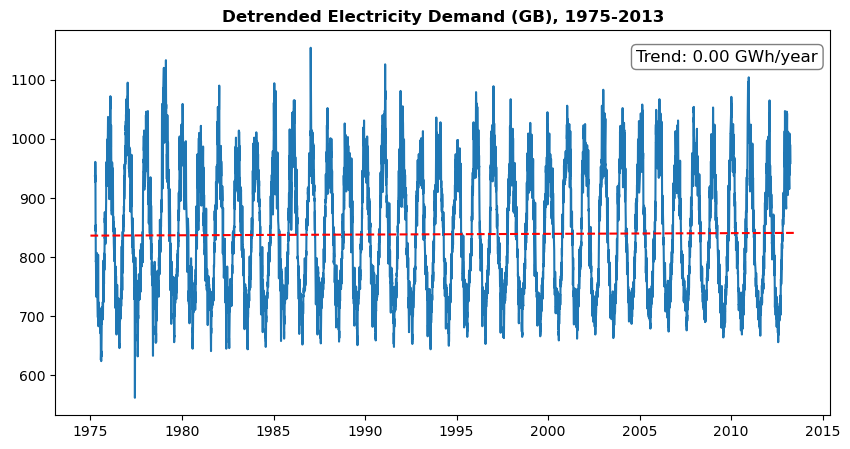

In [6]:
# plot the detrended electricity demand
plt.figure(figsize=(10, 5))

plt.plot(detrend_demand_df.index, detrend_demand_df['Detrended_demand_GWh'], label='Electricity Demand (GB)')

# remove Nans from the df
detrend_demand_df_no_nan = detrend_demand_df.dropna()

# fit a linear trend
z = np.polyfit(detrend_demand_df_no_nan.index.astype(int), detrend_demand_df_no_nan['Detrended_demand_GWh'], 1)

p = np.poly1d(z)

plt.plot(detrend_demand_df.index, p(detrend_demand_df.index.astype(int)), "r--", label='Trend')

# include the slope of the trend in a textbox in the top right
textstr = "Trend: {:.2f} GWh/year".format(z[0])

plt.text(0.75, 0.95, textstr, transform=plt.gca().transAxes, fontsize=12,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

# Set the title for detrended electricity demand
plt.title('Detrended Electricity Demand (GB), 1975-2013', fontweight='bold')

No trend in the annual data over the year, but when subset to DJF, there is a trend. Does this need to be removed?

In [7]:
# Process hazel demand data
# Make sure date is a datetime object
hazel_demand["date"] = pd.to_datetime(hazel_demand["date"], format="%Y-%m-%d")

# Set this as the index
hazel_demand.set_index("date", inplace=True)

In [8]:
hazel_demand.columns

Index(['elec_demand_5yrRmean', 'elec_demand_5yrRmean_nohols',
       'gas_demand_5yrRmean', 'gas_demand_5yrRmean_nohols', 'gas_demand_raw'],
      dtype='object')

Text(0.5, 1.0, 'Electricity Demand (GB), 1975-2013')

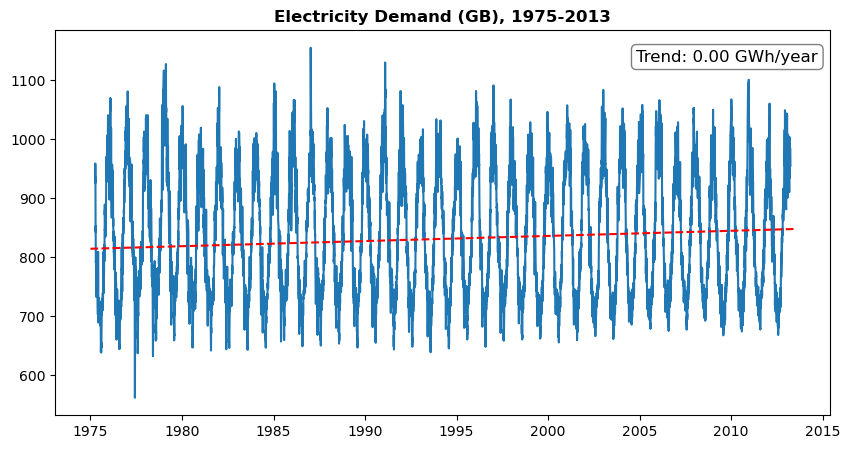

In [9]:
# plot the detrended electricity demand
plt.figure(figsize=(10, 5))

plt.plot(hazel_demand.index, hazel_demand['elec_demand_5yrRmean'], label='Electricity Demand (GB)')

# remove Nans from the df
hazel_demand_no_nan = hazel_demand.dropna()

# fit a linear trend
z = np.polyfit(hazel_demand_no_nan.index.astype(int), hazel_demand_no_nan['elec_demand_5yrRmean'], 1)

p = np.poly1d(z)

plt.plot(hazel_demand.index, p(hazel_demand.index.astype(int)), "r--", label='Trend')

# include the slope of the trend in a textbox in the top right
textstr = "Trend: {:.2f} GWh/year".format(z[0])

plt.text(0.75, 0.95, textstr, transform=plt.gca().transAxes, fontsize=12,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

# Set the title for detrended electricity demand
plt.title('Electricity Demand (GB), 1975-2013', fontweight='bold')

In [10]:
# join the two dataframes
hazel_demand = hazel_demand.join(detrend_demand_df, how='inner')

# drop tyhe Row_no column
hazel_demand.drop(columns=["Row_no"], inplace=True)

# subset to months 12, 1, 2
hazel_demand = hazel_demand[hazel_demand.index.month.isin([12, 1, 2])]

In [11]:
# Preprocess the CET data
# rename Value to CET_value
cet_data.rename(columns={"Value": "CET_value"}, inplace=True)

# Make sure that date is a datetime object
cet_data["Date"] = pd.to_datetime(cet_data["Date"], format="%Y-%m-%d")

# Set this as the index
cet_data.set_index("Date", inplace=True)

# subset to months 12, 1, 2
cet_data = cet_data[cet_data.index.month.isin([12, 1, 2])]

In [12]:
# Fold the comp path datasets together
comp_path_1940_1949.rename(columns={"Mean_sea_level_pressure": "air_pressure_at_mean_sea_level"}, inplace=True)

# join the two dataframes, on the Unnamed: 0 column
# where there are values in one dataframe but not the other, fill with NaN
comp_path = pd.concat([comp_path_1940_1949, comp_path_1950_2020], axis=0)

# Make sure that "Unnamed: 0" is a datetime
comp_path["Unnamed: 0"] = pd.to_datetime(comp_path["Unnamed: 0"])

# Set this as the index
comp_path.set_index("Unnamed: 0", inplace=True)

# restrict to months 12, 1, 2
comp_path_djf = comp_path[comp_path.index.month.isin([12, 1, 2])]

# Take daily means
comp_path_djf = comp_path_djf.resample("D").mean()

In [13]:
# join the comp_path_djf with the CET data
cet_comp = cet_data.join(comp_path_djf)

# join the cet_comp with the hazel demand data
cet_comp_demand = cet_comp.join(hazel_demand)

# join the SE temperature data
cet_comp_demand = cet_comp_demand.join(se_temp)

# limit between 1979 and 2013
cet_comp_demand = cet_comp_demand["1979-12-01":"2013-03-01"]

In [14]:
cet_comp_demand.tail()

,CET_value,100_metre_U_wind_component,100_metre_V_wind_component,2_metre_temperature,air_pressure_at_mean_sea_level,10_metre_U_wind_component,10_metre_V_wind_component,elec_demand_5yrRmean,elec_demand_5yrRmean_nohols,gas_demand_5yrRmean,gas_demand_5yrRmean_nohols,gas_demand_raw,Detrended_demand_GWh,t2m_south_england,t2m_london
2013-02-24,1.5,-2.202752,-4.574842,274.290850,102838.661851,-1.164825,-2.867094,992.340437,NaN,NaN,NaN,NaN,997.0,274.28530,274.03513
2013-02-25,2.3,-2.530495,-4.275996,275.473864,103206.273334,-1.428440,-2.703240,990.056876,990.056876,NaN,NaN,NaN,994.0,276.02344,275.84190
2013-02-26,3.7,-3.934151,-1.945699,275.943090,103572.313792,-2.485652,-1.382813,999.269196,999.269196,NaN,NaN,NaN,1004.0,276.61533,276.53360
2013-02-27,4.4,-1.379497,-2.212351,275.773869,103658.667234,-0.807243,-1.463380,980.477019,980.477019,NaN,NaN,NaN,985.0,276.20465,276.06216
2013-02-28,4.5,-1.511843,-4.215058,276.963282,103282.534647,-0.713970,-2.550698,966.679972,966.679972,NaN,NaN,NaN,971.0,276.52548,276.66592


In [15]:
# convert 2_metre_temperature to degrees C
cet_comp_demand["2_metre_temperature"] = cet_comp_demand["2_metre_temperature"] - 273.15

In [16]:
cet_comp_demand.columns

Index(['CET_value', '100_metre_U_wind_component', '100_metre_V_wind_component',
       '2_metre_temperature', 'air_pressure_at_mean_sea_level',
       '10_metre_U_wind_component', '10_metre_V_wind_component',
       'elec_demand_5yrRmean', 'elec_demand_5yrRmean_nohols',
       'gas_demand_5yrRmean', 'gas_demand_5yrRmean_nohols', 'gas_demand_raw',
       'Detrended_demand_GWh', 't2m_south_england', 't2m_london'],
      dtype='object')

In [17]:
# create a seasonal mean temperature dataframe to explore trends
season_mean_df = pd.DataFrame()

# Loop over the 
for year in np.arange(1979, 2012 + 1):
    # Subset the df
    subset_this = cet_comp_demand[f"{year}-12-01":f"{year + 1}-03-01"]

    # Set up a new df
    df_this = pd.DataFrame(
        {
            "CET_value": subset_this["CET_value"].mean(),
            "2_metre_temperature": subset_this["2_metre_temperature"].mean(),
            "electricity_demand_dt": subset_this["Detrended_demand_GWh"].mean(),
        },
        index=[year]
    )

    # Concat this to the new df
    season_mean_df = pd.concat([season_mean_df, df_this], axis=0)

In [18]:
season_mean_df.tail()

,CET_value,2_metre_temperature,electricity_demand_dt
2008,3.594444,3.784681,965.300000
2009,2.513978,2.265610,996.096774
2010,3.066667,3.055421,998.900000
2011,5.151648,5.060999,947.109890
2012,3.882222,3.855414,958.900000


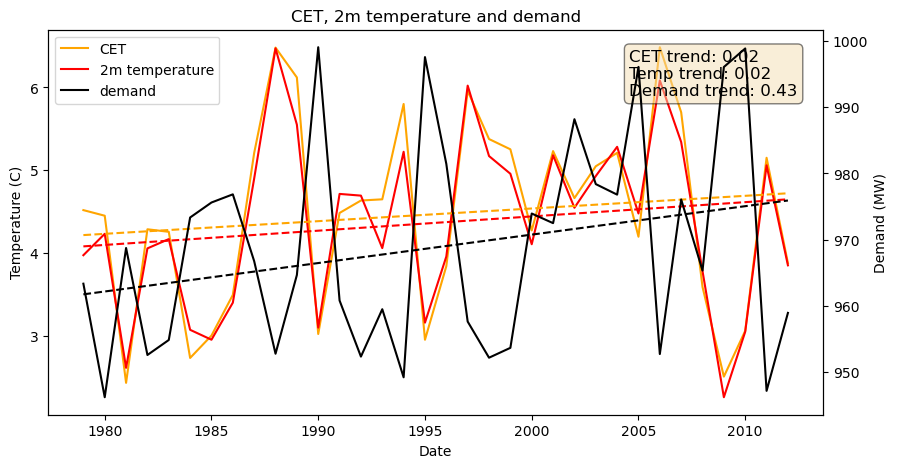

In [19]:
# Set up the figure
fig, ax = plt.subplots(figsize=(10, 5))

# plot the CET
line1, = ax.plot(season_mean_df["CET_value"], label="CET", color="orange")

# plot the 2m temperature
line2, = ax.plot(season_mean_df["2_metre_temperature"], label="2m temperature", color="red")

# create a second axis
ax2 = ax.twinx()

# plot the demand
line3, = ax2.plot(season_mean_df["electricity_demand_dt"], label="demand", color="k")

# quantify a linear trend for each
cet_trend = np.polyfit(np.arange(1979, 2013), season_mean_df["CET_value"], 1)
temp_trend = np.polyfit(np.arange(1979, 2013), season_mean_df["2_metre_temperature"], 1)
demand_trend = np.polyfit(np.arange(1979, 2013), season_mean_df["electricity_demand_dt"], 1)

# plot the trend lines as dashed lines
ax.plot(np.arange(1979, 2013), np.arange(1979, 2013) * cet_trend[0] + cet_trend[1], linestyle="--", color="orange")

ax.plot(np.arange(1979, 2013), np.arange(1979, 2013) * temp_trend[0] + temp_trend[1], linestyle="--", color="red")

ax2.plot(np.arange(1979, 2013), np.arange(1979, 2013) * demand_trend[0] + demand_trend[1], linestyle="--", color="k")

# include a textbox in the top right with the slope values
textstr = f"CET trend: {cet_trend[0]:.2f}\nTemp trend: {temp_trend[0]:.2f}\nDemand trend: {demand_trend[0]:.2f}"

# set up the textbox in the top tright
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place the textbox
ax.text(0.75, 0.95, textstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=props)

# set the labels
ax.set_ylabel("Temperature (C)")
ax2.set_ylabel("Demand (MW)")
ax.set_xlabel("Date")

# set the title
plt.title("CET, 2m temperature and demand")

# combine the legends
lines = [line1, line2, line3]
labels = [line.get_label() for line in lines]
ax.legend(lines, labels, loc='upper left')

# show the plot
plt.show()

Slight trend in the temperature, more of a trend in the demand (despite the annual trend having been removed in some way). Compare the correlations with and without trend removal.

In [20]:
cet_comp_demand.head()

,CET_value,100_metre_U_wind_component,100_metre_V_wind_component,2_metre_temperature,air_pressure_at_mean_sea_level,10_metre_U_wind_component,10_metre_V_wind_component,elec_demand_5yrRmean,elec_demand_5yrRmean_nohols,gas_demand_5yrRmean,gas_demand_5yrRmean_nohols,gas_demand_raw,Detrended_demand_GWh,t2m_south_england,t2m_london
1979-12-01,10.8,8.682175,4.836922,9.630994,101203.661435,5.354592,3.276997,906.516389,NaN,NaN,NaN,NaN,906.0,283.79477,283.97100
1979-12-02,10.7,7.464772,7.987720,10.325597,100903.042087,4.510977,5.251961,906.423927,NaN,NaN,NaN,NaN,906.0,285.34924,285.61948
1979-12-03,9.1,8.007458,6.421128,8.139982,101365.182003,4.869260,4.253926,895.831125,895.831125,NaN,NaN,NaN,895.0,283.20220,283.77972
1979-12-04,9.8,6.346158,10.460138,9.372562,101081.566929,3.669227,6.711869,936.737775,936.737775,NaN,NaN,NaN,936.0,283.39087,283.14886
1979-12-05,10.0,7.698610,2.985848,8.190843,101051.607150,4.693423,2.062627,937.643667,937.643667,NaN,NaN,NaN,937.0,283.78482,284.73853


In [21]:
from scipy import signal

# create new columns for detrended data
# fit a linear trend to the CET_value time series
cet_comp_demand["CET_value_dt"] = signal.detrend(cet_comp_demand["CET_value"])
cet_comp_demand["2_metre_temperature_dt"] = signal.detrend(cet_comp_demand["2_metre_temperature"])
cet_comp_demand["elec_demand_5yrRmean_dt"] = signal.detrend(cet_comp_demand["elec_demand_5yrRmean"])
cet_comp_demand["Detrended_demand_GWh_dt"] = signal.detrend(cet_comp_demand["Detrended_demand_GWh"])


In [22]:
# calculate the correlations in the df
correlations = cet_comp_demand.corr()

In [23]:
correlations["t2m_south_england"]

CET_value                         0.959991
100_metre_U_wind_component        0.538347
100_metre_V_wind_component        0.447924
2_metre_temperature               0.945936
air_pressure_at_mean_sea_level   -0.316655
10_metre_U_wind_component         0.523880
10_metre_V_wind_component         0.468632
elec_demand_5yrRmean             -0.675819
elec_demand_5yrRmean_nohols      -0.758336
gas_demand_5yrRmean              -0.810118
gas_demand_5yrRmean_nohols       -0.883221
gas_demand_raw                   -0.765858
Detrended_demand_GWh             -0.680105
t2m_south_england                 1.000000
t2m_london                        0.989456
CET_value_dt                      0.958651
2_metre_temperature_dt            0.944533
elec_demand_5yrRmean_dt          -0.683258
Detrended_demand_GWh_dt          -0.689159
Name: t2m_south_england, dtype: float64

Marginal difference, but CET temperature better correlated with electricity demand than UK wide temperature ~0.70 relative to ~0.65. Detrending winter data appears to make minimal difference (~0.01).

CET region (as selected in ERA5) only marginally better correlated (~0.68) with electricity demand than UK wide temperature (~0.66). HadCET dataset is more strongly correlated.

At both 10m and 100m, the U component of wind is more strongly anticorrelated (-0.45 compared to -0.3) than the V component of wind.

In this case, it seems like our "t2m_south_england" is the best bet as a proxy for demand (~0.7 correlation, ~0.76 when no holidays are considered.

Now we want to identify the box used for wind speed.

First let's consider the locations of wind turbines around the UK.

In [24]:
# # Set up the path to the file
# repd_path = "/home/users/benhutch/unseen_multi_year/data/wind_turbine_locations.csv"

# # # Read the file into a DataFrame with the specified encoding
# repd_df = pd.read_csv(repd_path, delimiter=',', header=0, encoding='ISO-8859-1')

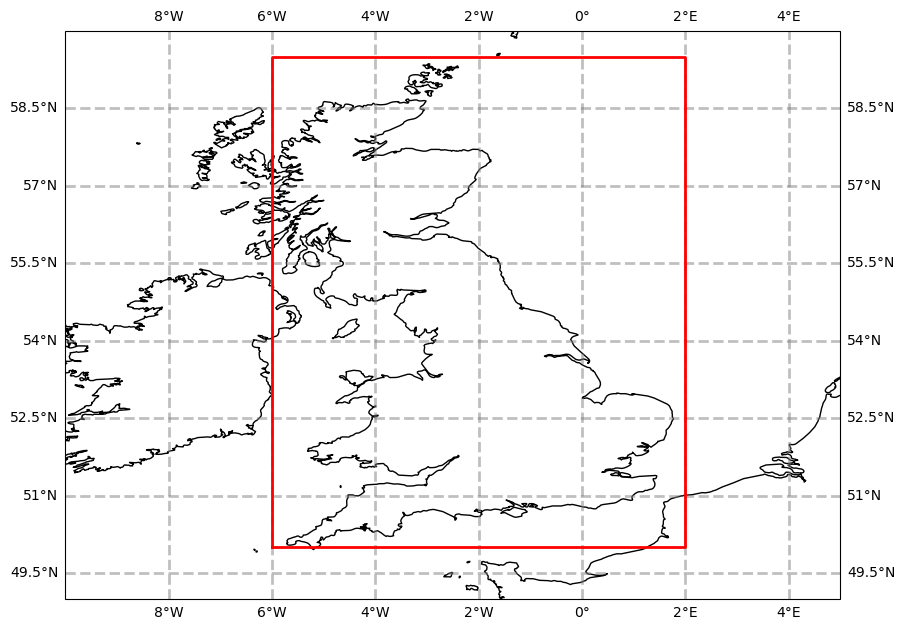

In [25]:
# plot a map of the UK
plt.figure(figsize=(10, 10))

# Set up the projection
ax = plt.axes(projection=ccrs.PlateCarree())

# Set up a test gridbox
wind_gridbox = {
    "lat1": 50,
    "lat2": 59.5,
    "lon1": -6,
    "lon2": 2
}

# Set up the extent
ax.set_extent([-10, 5, 49, 60], crs=ccrs.PlateCarree())

# Add coastlines
ax.coastlines(resolution='10m')

# Add gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')

# Label the gridlines
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# Add the gridbox specified
ax.plot(
    [wind_gridbox["lon1"], wind_gridbox["lon2"], wind_gridbox["lon2"], wind_gridbox["lon1"], wind_gridbox["lon1"]],
    [wind_gridbox["lat1"], wind_gridbox["lat1"], wind_gridbox["lat2"], wind_gridbox["lat2"], wind_gridbox["lat1"]],
    color='red',
    linewidth=2,
    transform=ccrs.PlateCarree()
)

Based on this map (https://renewables-map.robinhawkes.com/#4.83/54.42/-0.9), this seems like a reasonable approximation of where wind farms currently are.

In [26]:
# Set up the path to the wind data
# Load and process the observed data to compare against
# Set up the path to the observed data
base_path = "/gws/nopw/j04/canari/users/benhutch/ERA5/"

obs_path = os.path.join(base_path, "ERA5_wind_daily_1952_2020.nc")

# Load the observed data using iris
obs_data = iris.load_cube(obs_path, "si10")

In [27]:
# Make sure the dimensions are correct
obs_data = obs_data.intersection(longitude=(-180, 180))

# Subset to the box
obs_data_box = obs_data.intersection(latitude=(wind_gridbox["lat1"], wind_gridbox["lat2"]),
                                 longitude=(wind_gridbox["lon1"], wind_gridbox["lon2"]))

# Take the mean over the box
obs_data_box_mean = obs_data_box.collapsed(["latitude", "longitude"], iris.analysis.MEAN)

/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/iris/cube.py:4330: IrisUserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(
/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/iris/coords.py:2171: IrisVagueMetadataWarning: Cannot check if coordinate is contiguous: Invalid operation for 'latitude', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'latitude'. Ignoring bounds.
  warnings.warn(
/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/iris/coords.py:2171: IrisVagueMetadataWarning: Cannot check if coordinate is contiguous: Invalid operation for 'longitude', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'longitude'. Ignoring bounds.
  warnings.warn(


In [28]:
# Extract the times from the obs_data_box_mean
times = obs_data_box_mean.coord("time").points

# Set up the dataframe
obs_df = pd.DataFrame(
    {
        "time": times,
        "10m_wind_speed_UK": obs_data_box_mean.data
    }
)

In [29]:
# persist the data
obs_df.to_csv("/home/users/benhutch/unseen_multi_year/dfs/ERA5_UK_wind_speed_1952_2020_Feb24.csv")

In [31]:
obs_df.tail()

,time,10m_wind_speed_UK
25198,25198,8.210904
25199,25199,4.551947
25200,25200,6.011140
25201,25201,5.198114
25202,25202,5.591417


In [32]:
# convert the time to a datetime
# it is in days since 1952-01-01
obs_df["time"] = pd.to_datetime(obs_df["time"], unit="D", origin="1952-01-01")

In [33]:
obs_df.set_index("time", inplace=True)

In [34]:
# Subset to months 12, 1, 2
obs_df = obs_df[obs_df.index.month.isin([12, 1, 2])]

# Subset to 1952-12-01 to 2020-03-01
obs_df = obs_df["1952-12-01":"2020-03-01"]

In [35]:
obs_df.head()

,10m_wind_speed_UK
time,
1952-12-01,6.052902
1952-12-02,7.091066
1952-12-03,7.998949
1952-12-04,4.383369
1952-12-05,4.115603


In [36]:
obs_df.tail()

,10m_wind_speed_UK
time,
2020-02-25,6.547364
2020-02-26,7.593943
2020-02-27,7.632037
2020-02-28,8.310860
2020-02-29,10.555199


In [40]:
# join se_temp with cet_comp
cet_comp_obs = cet_comp.join(se_temp)

In [43]:
# limit to 1952-12-01 to 2020-03-01
cet_comp_obs = cet_comp_obs["1952-12-01":"2020-03-01"]

# join the cet_comp_obs with the obs_df
cet_comp_obs = cet_comp_obs.join(obs_df)

In [45]:
cet_comp_obs.tail()

,CET_value,100_metre_U_wind_component,100_metre_V_wind_component,2_metre_temperature,air_pressure_at_mean_sea_level,10_metre_U_wind_component,10_metre_V_wind_component,t2m_south_england,t2m_london,10m_wind_speed_UK
Date,,,,,,,,,,
2020-02-25,5.2,7.638475,1.074252,276.532108,99612.314484,4.831621,0.895335,277.97525,278.46445,6.547364
2020-02-26,4.3,8.234815,-0.833189,276.085486,100049.303831,5.237808,-0.425437,277.01430,277.03230,7.593943
2020-02-27,3.9,6.491643,-1.106576,276.189254,100165.326576,3.994786,-0.714246,276.92026,276.77954,7.632037
2020-02-28,5.9,1.386618,7.921559,278.052359,99823.469500,0.426174,4.868676,278.91498,278.76996,8.310860
2020-02-29,5.3,5.677213,8.560554,278.562108,97580.521958,3.572449,5.652267,280.07593,280.43768,10.555199


In [47]:
# if not already done, convert 2_metre_temperature to degrees C
if "2_metre_temperature" in cet_comp_obs.columns:
    cet_comp_obs["2_metre_temperature"] = cet_comp_obs["2_metre_temperature"] - 273.15

In [64]:
# Calculate 100m wind speed
cet_comp_obs["100m_wind_speed"] = np.sqrt(cet_comp_obs["100_metre_U_wind_component"] ** 2 + cet_comp_obs["100_metre_V_wind_component"] ** 2)

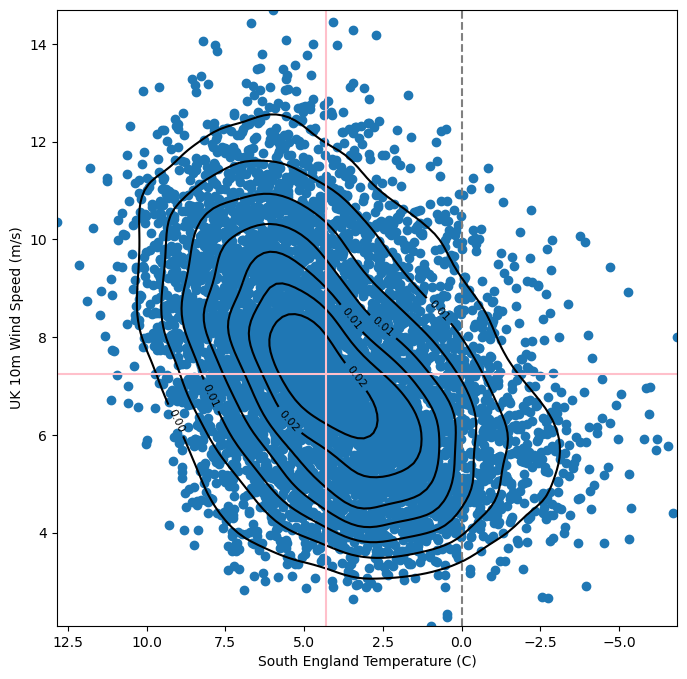

In [63]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# First do the plot with density contours
# Set up the figure
fig, ax = plt.subplots(figsize=(8, 8))

# Plot the scatter plot
sc = ax.scatter(cet_comp_obs["2_metre_temperature"], cet_comp_obs["10m_wind_speed_UK"])

# include a grey dashed line for the 0 line
ax.axvline(0, linestyle="--", color="grey")

# reverse the x-axis
ax.invert_xaxis()

# Set the labels
ax.set_xlabel("South England Temperature (C)")
ax.set_ylabel("UK 10m Wind Speed (m/s)")

# Estimate the density
x = cet_comp_obs["2_metre_temperature"]
y = cet_comp_obs["10m_wind_speed_UK"]
xy = np.vstack([x, y])
z = gaussian_kde(xy)(xy)

# Create a grid of points where the density will be evaluated
xmin, xmax = x.min(), x.max()
ymin, ymax = y.min(), y.max()
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
density = np.reshape(gaussian_kde(xy)(positions).T, xx.shape)

# Plot the density contours
contours = ax.contour(xx, yy, density, colors='k')

# Add labels to the contours
ax.clabel(contours, inline=True, fontsize=8, fmt="%1.2f")

# include pink lines showing the median values
ax.axvline(cet_comp_obs["2_metre_temperature"].median(), color="pink")
ax.axhline(cet_comp_obs["10m_wind_speed_UK"].median(), color="pink")

plt.show()

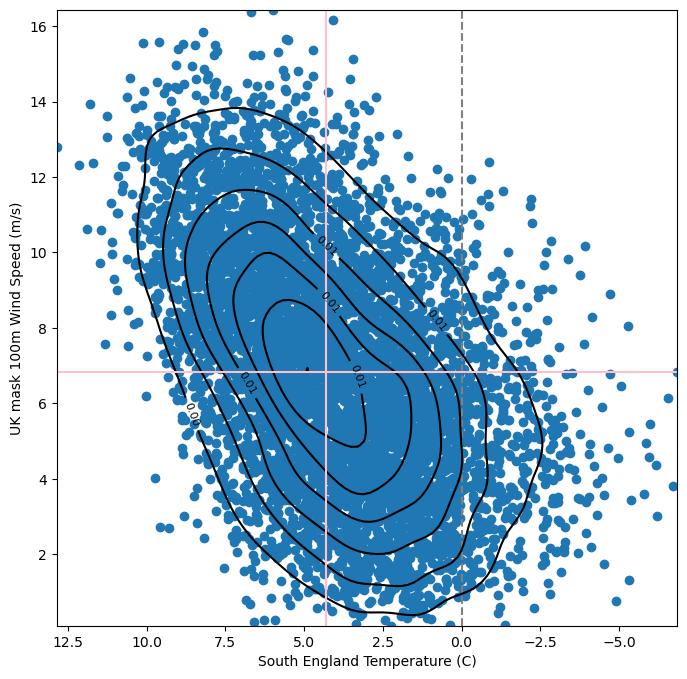

In [66]:
# Do the same but for 100m wind speed
# NOTE: different masking
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# First do the plot with density contours
# Set up the figure
fig, ax = plt.subplots(figsize=(8, 8))

# Plot the scatter plot
sc = ax.scatter(cet_comp_obs["2_metre_temperature"], cet_comp_obs["100m_wind_speed"])

# include a grey dashed line for the 0 line
ax.axvline(0, linestyle="--", color="grey")

# reverse the x-axis
ax.invert_xaxis()

# Set the labels
ax.set_xlabel("South England Temperature (C)")
ax.set_ylabel("UK mask 100m Wind Speed (m/s)")

# Estimate the density
x = cet_comp_obs["2_metre_temperature"]
y = cet_comp_obs["100m_wind_speed"]
xy = np.vstack([x, y])
z = gaussian_kde(xy)(xy)

# Create a grid of points where the density will be evaluated
xmin, xmax = x.min(), x.max()
ymin, ymax = y.min(), y.max()
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
density = np.reshape(gaussian_kde(xy)(positions).T, xx.shape)

# Plot the density contours
contours = ax.contour(xx, yy, density, colors='k')

# Add labels to the contours
ax.clabel(contours, inline=True, fontsize=8, fmt="%1.2f")

# include pink lines showing the median values
ax.axvline(cet_comp_obs["2_metre_temperature"].median(), color="pink")
ax.axhline(cet_comp_obs["100m_wind_speed"].median(), color="pink")

plt.show()

In [67]:
cet_comp_obs.columns

Index(['CET_value', '100_metre_U_wind_component', '100_metre_V_wind_component',
       '2_metre_temperature', 'air_pressure_at_mean_sea_level',
       '10_metre_U_wind_component', '10_metre_V_wind_component',
       't2m_south_england', 't2m_london', '10m_wind_speed_UK',
       '100m_wind_speed'],
      dtype='object')

In [74]:
# Now set up the next plot for percentiles
percentiles_df = pd.DataFrame()

percentiles_5 = np.arange(0, 95 + 1, 1)

# loop over the percentiles
for perc_this in percentiles_5:
    # Find the lower and upper bound
    lower_bound = perc_this / 100
    upper_bound = (perc_this + 5) / 100

    # Find the values
    temp_lower_bound = cet_comp_obs["2_metre_temperature"].quantile(lower_bound)
    temp_upper_bound = cet_comp_obs["2_metre_temperature"].quantile(upper_bound)

    # Subset the dataframe to these values
    subset_this = cet_comp_obs[(cet_comp_obs["2_metre_temperature"] >= temp_lower_bound) & (cet_comp_obs["2_metre_temperature"] <= temp_upper_bound)]

    # extract the valid dates
    valid_dates = subset_this.dropna(subset=["2_metre_temperature"]).index

    # Make sure these are lists of strs in the yyyy-mm-dd format
    valid_dates= [str(date_this.date()) for date_this in valid_dates]

    # Set up a new df
    df_this = pd.DataFrame(
        {
            "percentile": [((lower_bound + upper_bound) / 2) * 100],
            "lower_bound": [temp_lower_bound],
            "upper_bound": [temp_upper_bound],
            "valid_dates": [valid_dates],
            "n_dates": [len(valid_dates)],
            "mean_t2m_south_england": [subset_this["t2m_south_england"].mean()],
            "mean_psl": [subset_this["air_pressure_at_mean_sea_level"].mean()],
            "mean_100m_wind_speed_UK_mask": [subset_this["100m_wind_speed"].mean()],
            "mean_10m_wind_speed_UK": [subset_this["10m_wind_speed_UK"].mean()],
        }
    )

    # Concat the dataframes
    percentiles_df = pd.concat([percentiles_df, df_this], axis=0)

In [76]:
percentiles_df.head()

,percentile,lower_bound,upper_bound,valid_dates,n_dates,mean_t2m_south_england,mean_psl,mean_100m_wind_speed_UK_mask,mean_10m_wind_speed_UK
0,2.5,-6.844836,-0.934697,"[1953-01-03, 1953-02-07, 1954-01-27, 1954-01-2...",307,271.058384,101486.875883,4.997691,6.090233
0,3.5,-3.111803,-0.631713,"[1952-12-15, 1953-01-03, 1953-02-07, 1954-01-0...",307,271.757210,101444.070650,5.185000,6.189629
0,4.5,-2.415287,-0.379205,"[1952-12-04, 1952-12-15, 1953-01-03, 1953-01-0...",307,272.235326,101491.176215,5.235869,6.229524
0,5.5,-1.819598,-0.085310,"[1952-12-04, 1952-12-15, 1953-01-02, 1953-01-0...",306,272.624783,101499.536721,5.190207,6.283950
0,6.5,-1.271929,0.084420,"[1952-12-04, 1952-12-14, 1952-12-15, 1953-01-0...",307,272.937746,101498.681159,5.326296,6.408404


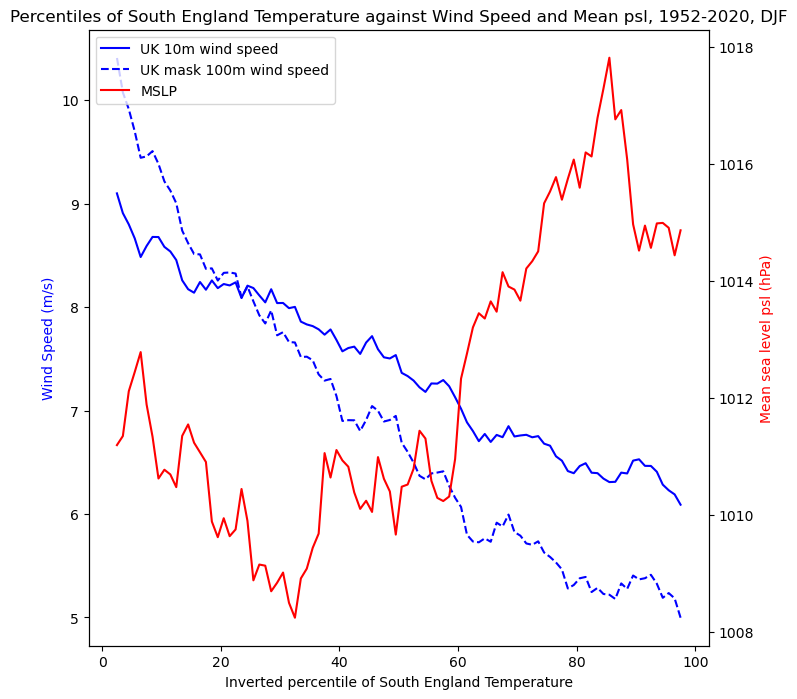

In [80]:
# Set up the figure
fig, ax = plt.subplots(figsize=(8, 8))

# Plot the percentiles against UK 10m wind speed`
ax.plot(100 - percentiles_df["percentile"], percentiles_df["mean_10m_wind_speed_UK"], label="UK 10m wind speed", color="blue")

# Plot the percentiles against UK mask 100m wind speed
ax.plot(100 - percentiles_df["percentile"], percentiles_df["mean_100m_wind_speed_UK_mask"], label="UK mask 100m wind speed", color="blue", linestyle="--")

# Set up a second axis
ax2 = ax.twinx()

# Plot the percentiles against mean psl
ax2.plot(100 - percentiles_df["percentile"], percentiles_df["mean_psl"] / 100, label="MSLP", color="red")

# Set the labels
ax.set_xlabel("Inverted percentile of South England Temperature")

# Set the labels
ax.set_ylabel("Wind Speed (m/s)", color="blue")

# Set the labels
ax2.set_ylabel("Mean sea level psl (hPa)", color="red")

# Set the title
plt.title("Percentiles of South England Temperature against Wind Speed and Mean psl, 1952-2020, DJF")

# Combine the legends
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()

ax.legend(lines + lines2, labels + labels2, loc='upper left')

plt.show()

Can we get the same, but with UK N-S pressure difference?

Would detrending affect this in any way?

In [81]:
# set up the path to the data
nao_path = "/home/users/benhutch/unseen_multi_year/dfs/nao_delta_p_indices_1975_2015.csv"

# import the data
nao = pd.read_csv(nao_path)

In [82]:
# set time as a datetime
nao["time"] = pd.to_datetime(nao["time"])

# set time as the index
nao.set_index("time", inplace=True)

# subset nao to djf
nao_djf = nao[nao.index.month.isin([12, 1, 2])]

In [83]:
# join the cet_comp_obs with the nao_djf
cet_comp_obs_nao = cet_comp_obs.join(nao_djf)

In [87]:
cet_comp_obs_nao.head()

,CET_value,100_metre_U_wind_component,100_metre_V_wind_component,2_metre_temperature,air_pressure_at_mean_sea_level,10_metre_U_wind_component,10_metre_V_wind_component,t2m_south_england,t2m_london,10m_wind_speed_UK,100m_wind_speed,nao_index,delta_p_index
Date,,,,,,,,,,,,,
1975-12-01,4.0,3.171432,7.122584,4.154240,99717.807536,1.618314,4.427107,278.22590,277.93384,8.747808,7.796742,14.628906,-16.762109
1975-12-02,4.7,3.756798,-7.526635,5.070138,99601.409722,2.478484,-4.731663,279.46940,279.87590,10.569183,8.412121,18.668359,-10.334375
1975-12-03,4.4,5.284362,-5.528705,4.032463,101992.279245,3.266658,-3.114017,276.66736,276.39140,8.802579,7.647945,34.973984,-20.285625
1975-12-04,5.5,7.718601,-0.496779,6.999576,102518.790314,4.450234,0.072993,279.36740,277.84400,6.897380,7.734571,15.645469,-25.990313
1975-12-05,8.1,7.283576,-2.196655,8.973743,102824.601140,4.430800,-0.966233,282.20078,281.71664,6.883789,7.607613,7.884062,-20.654531


In [85]:
# limit between 1975-12-01 and 2015-03-01
cet_comp_obs_nao = cet_comp_obs_nao["1975-12-01":"2015-03-01"]

In [88]:
# Now set up the next plot for percentiles
percentiles_df = pd.DataFrame()

percentiles_5 = np.arange(0, 95 + 1, 1)

# loop over the percentiles
for perc_this in percentiles_5:
    # Find the lower and upper bound
    lower_bound = perc_this / 100
    upper_bound = (perc_this + 5) / 100

    # Find the values
    temp_lower_bound = cet_comp_obs_nao["2_metre_temperature"].quantile(lower_bound)
    temp_upper_bound = cet_comp_obs_nao["2_metre_temperature"].quantile(upper_bound)

    # Subset the dataframe to these values
    subset_this = cet_comp_obs_nao[(cet_comp_obs_nao["2_metre_temperature"] >= temp_lower_bound) & (cet_comp_obs_nao["2_metre_temperature"] <= temp_upper_bound)]

    # extract the valid dates
    valid_dates = subset_this.dropna(subset=["2_metre_temperature"]).index

    # Make sure these are lists of strs in the yyyy-mm-dd format
    valid_dates= [str(date_this.date()) for date_this in valid_dates]

    # Set up a new df
    df_this = pd.DataFrame(
        {
            "percentile": [((lower_bound + upper_bound) / 2) * 100],
            "lower_bound": [temp_lower_bound],
            "upper_bound": [temp_upper_bound],
            "valid_dates": [valid_dates],
            "n_dates": [len(valid_dates)],
            "mean_t2m_south_england": [subset_this["t2m_south_england"].mean()],
            "mean_psl": [subset_this["air_pressure_at_mean_sea_level"].mean()],
            "mean_100m_wind_speed_UK_mask": [subset_this["100m_wind_speed"].mean()],
            "mean_10m_wind_speed_UK": [subset_this["10m_wind_speed_UK"].mean()],
            "mean_nao": [subset_this["nao_index"].mean()],
            "mean_delta_p": [subset_this["delta_p_index"].mean()],
        }
    )

    # Concat the dataframes
    percentiles_df = pd.concat([percentiles_df, df_this], axis=0)

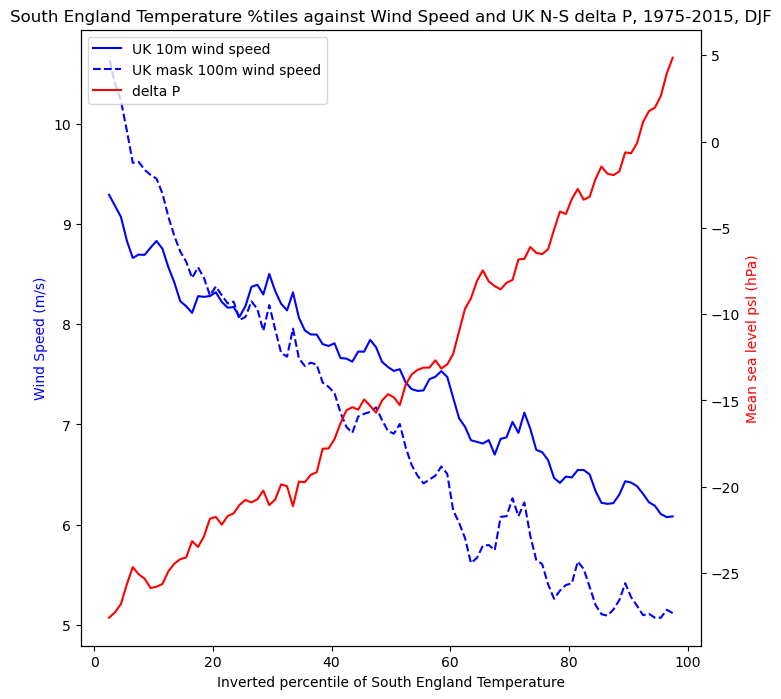

In [89]:
# Set up the figure
fig, ax = plt.subplots(figsize=(8, 8))

# Plot the percentiles against UK 10m wind speed`
ax.plot(100 - percentiles_df["percentile"], percentiles_df["mean_10m_wind_speed_UK"], label="UK 10m wind speed", color="blue")

# Plot the percentiles against UK mask 100m wind speed
ax.plot(100 - percentiles_df["percentile"], percentiles_df["mean_100m_wind_speed_UK_mask"], label="UK mask 100m wind speed", color="blue", linestyle="--")

# Set up a second axis
ax2 = ax.twinx()

# Plot the percentiles against mean psl
ax2.plot(100 - percentiles_df["percentile"], percentiles_df["mean_delta_p"], label="delta P", color="red")

# Set the labels
ax.set_xlabel("Inverted percentile of South England Temperature")

# Set the labels
ax.set_ylabel("Wind Speed (m/s)", color="blue")

# Set the labels
ax2.set_ylabel("Mean sea level psl (hPa)", color="red")

# Set the title
plt.title("South England Temperature %tiles against Wind Speed and UK N-S delta P, 1975-2015, DJF")

# Combine the legends
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()

ax.legend(lines + lines2, labels + labels2, loc='upper left')

plt.show()